In [1]:
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from ProcessOptimizer import Optimizer

# Filling the parameter space with ProcessOptimizer
AZOB- November 2020 <br>
This notebook illustrates how to ask for parameters values for space filling after initial experiments have already been carried out. <br> Let us imagine an experiment where an experimentalist has studied the yield of a reaction as a function of temperature with a fixed pressure value(=1). <br> The experimentalist has conducted her experiments at temperatures of 0.5, 1, 1.5 and 2. The results are shown below:

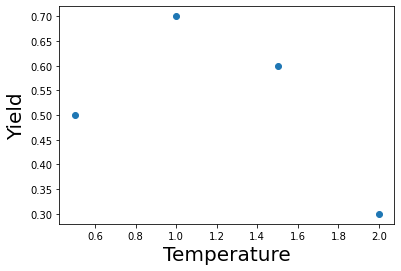

In [2]:
temp, exp_yield=np.array([0.5,1,1.5,2]), np.array([0.5,0.7,0.6,0.3])
plt.scatter(temp, exp_yield)
plt.xlabel("Temperature",fontsize=20), plt.ylabel("Yield",fontsize=20);

At this point the experimentalist realizes that she also wants to examine the pressure dependence. She already knows that the bounds for temperature is [0:3] and the pressure bounds are [0.1:2]. <br> She decides to visualise the points in the 2d parameter space which she has investigated so far: 

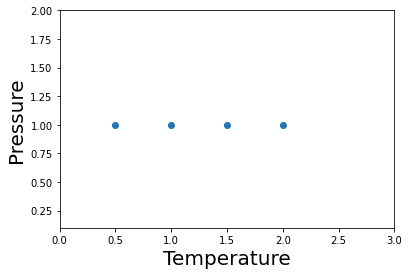

In [3]:
pressure= np.ones(4)
plt.scatter(temp, pressure)
plt.xlabel("Temperature",fontsize=20), plt.ylabel("Pressure",fontsize=20);
plt.xlim([0,3]), plt.ylim([0.1,2]);

Since the optimization problem is now multidimensional and unintuitive, she decides to solve it using a Bayesian Optimizer. Therefore she constructs an optimizer using the ProcessOptimizer library. She chooses Gaussian processes for the surogate model. <br> She wants to utilize the experiments she already recorded. Therefore she tells the results to the classifier:

In [4]:
from ProcessOptimizer.space import Integer, Categorical, Real 
SPACE = [
    Real(0, 3, name='max_depth'),
    Real(0.1, 2, name='min_samples_split'),
]
opt = Optimizer(SPACE, "ET")
for i in range(len(temp)):
    opt.tell([temp[i],pressure[i]],exp_yield[i])

In [5]:
opt.space

Space([Real(low=0, high=3, prior='uniform', transform='identity'),
       Real(low=0.1, high=2, prior='uniform', transform='identity')])

The experimentalist know figures that she needs to explore the parameter space, before computing a surogate model, since her points are contained within a very local region. She wants to ask for 10 new points in the parameter space, however she is not quite sure what the right approach is. She considers 3 approaches:
* Random space filling 
* Latin hypercube sampling 
* Steinerberger sampling
<br>

She asks for points with the .ask() function and uses the 'space_fill' argument to specify the space filling strategy.

In [6]:
New_points_rand= np.asarray(opt.ask(space_fill="rand",n_points=10))
New_points_lhs=np.asarray(opt.ask(space_fill="lhs",n_points=10))
New_points_stbr=np.asarray(opt.ask(space_fill="stbr",n_points=10))

These point are illustrared below for each of the 3 methods. The experimentalist notices that each method provides samples covering some of the space which has not yet been explored.

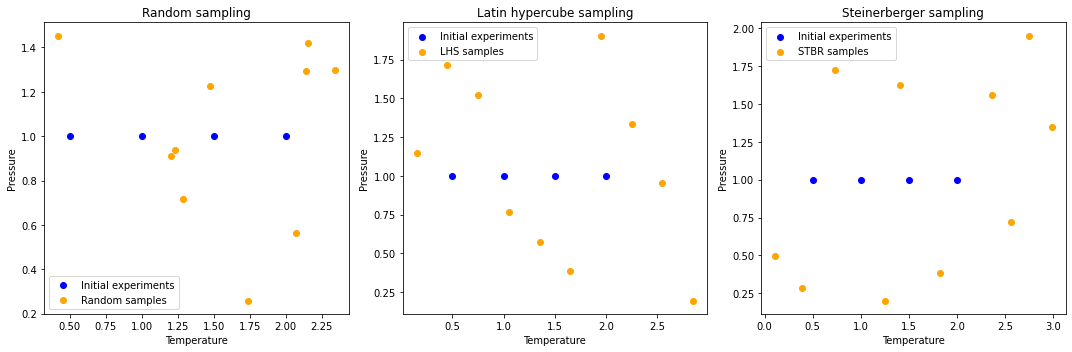

In [7]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))
ax1.scatter(temp, pressure,c="b",label="Initial experiments")
ax1.scatter(New_points_rand[:,0],New_points_rand[:,1],c="orange",label="Random samples")
ax1.set(xlabel="Temperature",ylabel="Pressure",title="Random sampling")
ax1.legend()
ax2.scatter(temp, pressure,c="b",label="Initial experiments")
ax2.scatter(New_points_lhs[:,0],New_points_lhs[:,1],c="orange",label="LHS samples")
ax2.set(xlabel="Temperature",ylabel="Pressure",title="Latin hypercube sampling")
ax2.legend()
ax3.scatter(temp, pressure,c="b",label="Initial experiments")
ax3.scatter(New_points_stbr[:,0],New_points_stbr[:,1],c="orange",label="STBR samples")
ax3.set(xlabel="Temperature",ylabel="Pressure",title="Steinerberger sampling")
ax3.legend()

plt.tight_layout()

She concludes that random and LHS sampling both provide points which are too close to her existing data points to be interesting and leave too large areas of the sample space unexplored. Steinerberger sampling however covers the parameter space nicely and due to the nature of the technique, no sample points are extremely close to each other.

# Short example with Steinerberger sampling in 3D
Below we construct a 3D optimizer, tell it 4 observations and ask for 10 new points to evaluate at by Steinerberger sampling. <br> Furthermore the returned points are visualized.

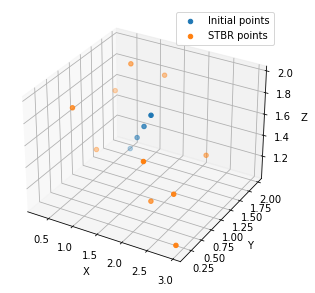

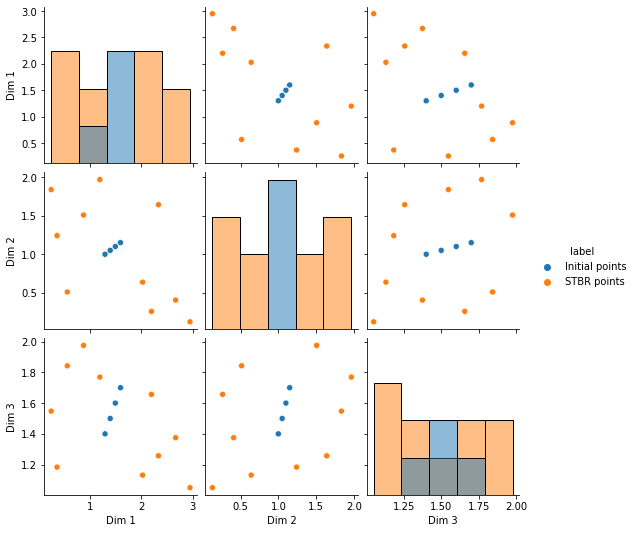

In [9]:
dims=[(0, 3.0),(0.1,2.0),(1,2.0)]
opt3D = Optimizer(dims, "GP")
init_3D=[[1.3,1.0,1.4],[1.4,1.05,1.5],[1.5,1.1,1.6],[1.6,1.15,1.7]]
opt3D.tell(init_3D,np.ones(4).tolist())
init_3D=np.asarray(init_3D)
New_points_stbr_3D=np.asarray(opt3D.ask(space_fill="stbr",n_points=10))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d');
ax.scatter(init_3D[:,0],init_3D[:,1], zs=init_3D[:,2], zdir='z', s=20, c=None, depthshade=True,label="Initial points")
ax.scatter(New_points_stbr_3D[:,0], New_points_stbr_3D[:,1], zs=New_points_stbr_3D[:,2], zdir='z', s=20, 
           c=None, depthshade=True,label="STBR points")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()

import seaborn as sns
import pandas as pd

DataFrame_init=pd.DataFrame(init_3D.tolist(), columns=["Dim 1", "Dim 2", "Dim 3"])
DataFrame_init["label"]=["Initial points"]*len(DataFrame_init)
DataFrame=pd.DataFrame(New_points_stbr_3D, columns=["Dim 1", "Dim 2", "Dim 3"])
DataFrame["label"]=["STBR points"]*len(DataFrame)
DataFrame=DataFrame_init.append(DataFrame)
sns.pairplot(DataFrame,hue="label", diag_kind="hist")

# Short example with Steinerberger sampling in 8D (including integer dimension)
Below we construct an 8D optimizer, tell it 4 observations and ask for 20 new points to evaluate at. <br> Furthermore the returned points are visualized. Notice that the last dimension is integer (1,2,3).

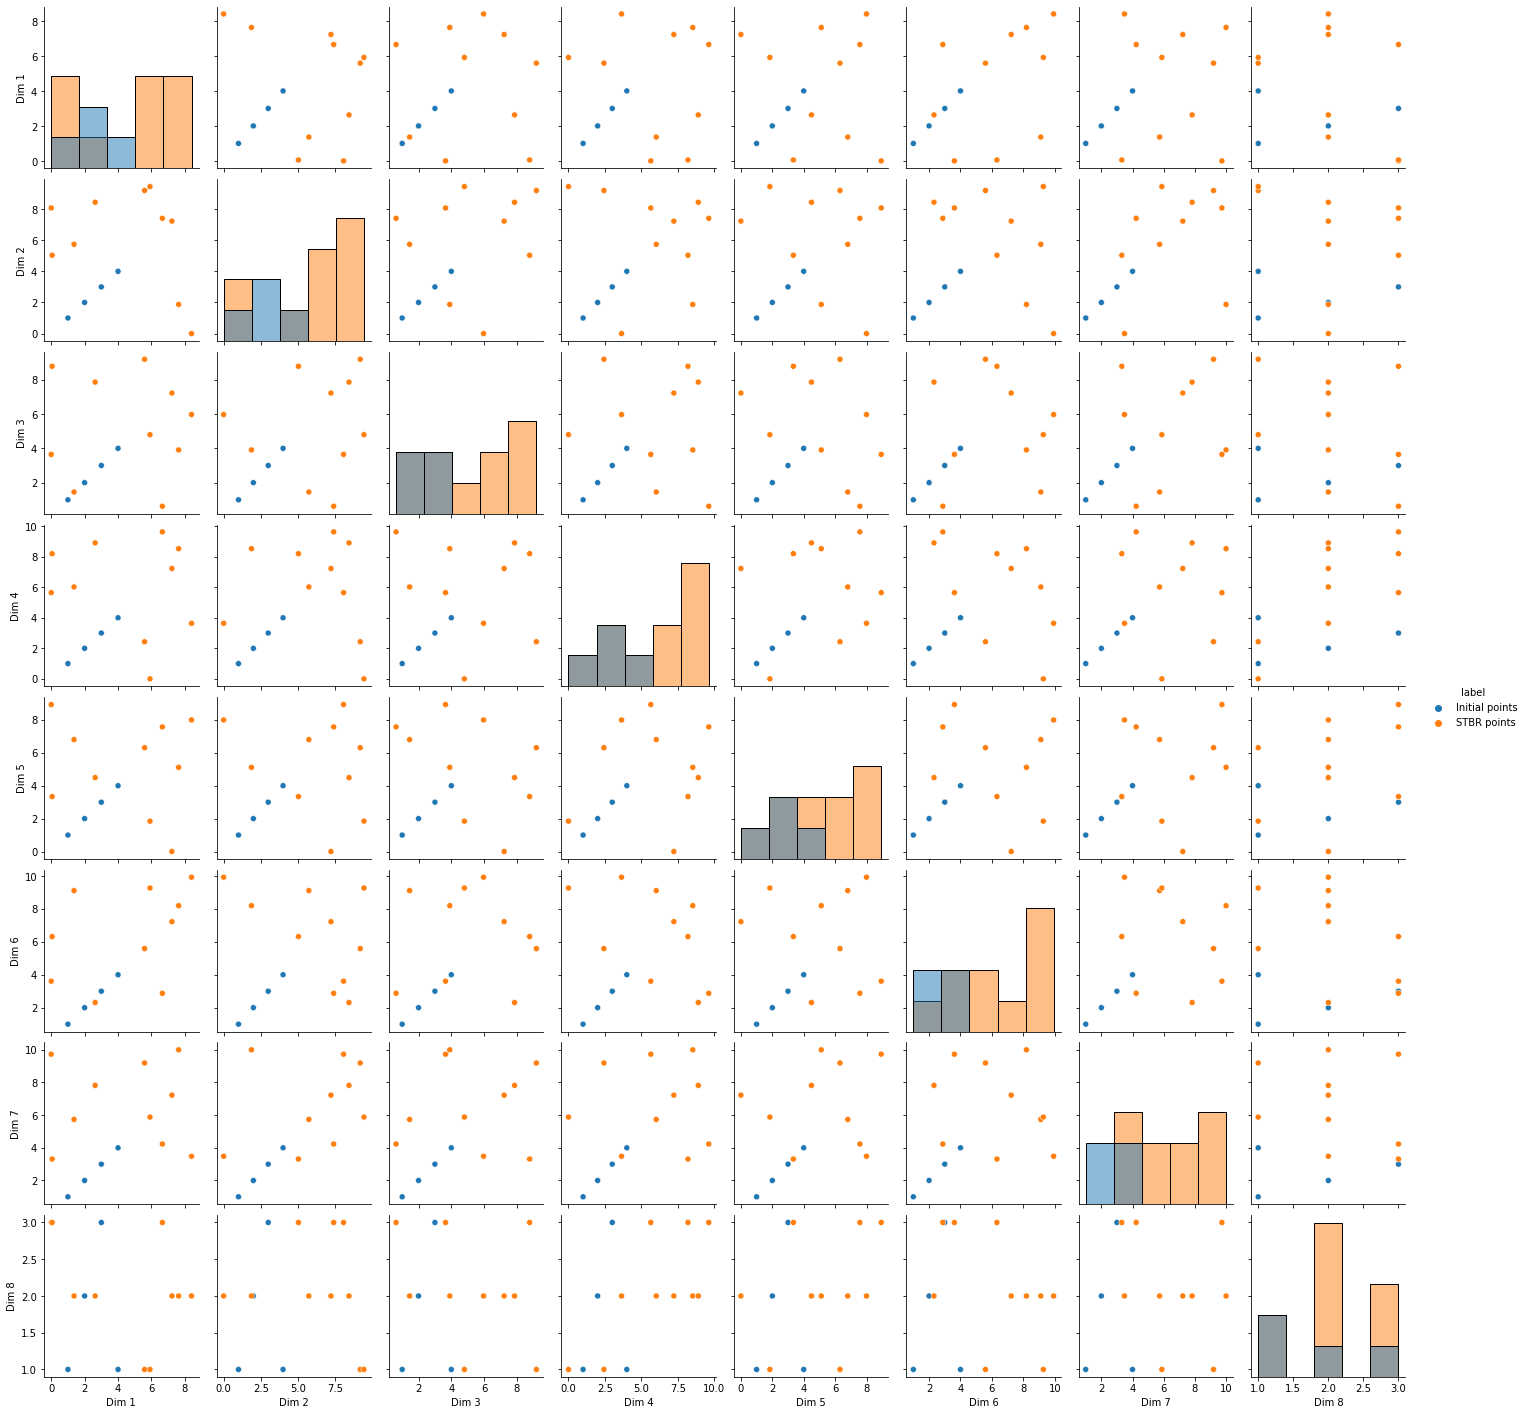

In [10]:
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt
from ProcessOptimizer import Optimizer
from ProcessOptimizer.space import Integer

import seaborn as sns
import pandas as pd
dims=[(0.0,10.0)]*7
dims.append(Integer(1, 3))
opt8D = Optimizer(dims, "GP")
init_8D=[[1,1,1,1,1,1,1,1],[2,2,2,2,2,2,2,2],[3,3,3,3,3,3,3,3],[4,4,4,4,4,4,4,1]]
opt8D.tell(init_8D,np.ones(4).tolist())
New_points_stbr_8D=opt8D.ask(space_fill="stbr",n_points=10)

DataFrame_init=pd.DataFrame(init_8D, columns=["Dim 1", "Dim 2", "Dim 3", "Dim 4",
                                                      "Dim 5", "Dim 6", "Dim 7", "Dim 8"])
DataFrame_init["label"]=["Initial points"]*len(DataFrame_init)
DataFrame=pd.DataFrame(New_points_stbr_8D, columns=["Dim 1", "Dim 2", "Dim 3", "Dim 4",
                                                      "Dim 5", "Dim 6", "Dim 7", "Dim 8"])
DataFrame["label"]=["STBR points"]*len(DataFrame)
DataFrame=DataFrame_init.append(DataFrame)
sns.pairplot(DataFrame,hue="label", diag_kind="hist")

# Dealing with Categorical variables <br>
This example illustrates how we deal with categorical variables. <br>
For eachg categorical variable the category with the lowest population is assigned. <br>
The categorical dimensions are:

*     Categorical(list('abc'), name='dummy')
*     Categorical(['gini', 'entropy'], name='criterion')
*     Categorical(list('def'), name='dummy') <br>

Since the first observation has the categories 'b', 'gini' and 'e', the next observation should have the categories 'a or c', 'entropy' and 'd or f' since these are not populated. The Steinerberger points can be seen in the output. The categories are always assigned with this lowest population logic.




In [11]:
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt
from ProcessOptimizer import Optimizer
from ProcessOptimizer.space import Integer, Categorical, Real
SPACE = [
    Integer(0, 100, name='max_depth'),
    Real(0.1, 10, name='min_samples_split'),
    Real(5, 30, name='min_samples_leaf'),
    Real(1, 30, name='max_features'),
    Categorical(list('abc'), name='dummy'),
    Categorical(['gini', 'entropy'], name='criterion'),
    Categorical(list('def'), name='dummy'),
]
optcat = Optimizer(SPACE, "GP",lhs=True)
optcat.tell([20, 7.8, 30, 1, 'b', 'gini', 'e'],1)


optcat.ask(space_fill='stbr',n_points=5)

[[71,
  3.013400778909773,
  17.211522262233323,
  15.23489834322814,
  'a',
  'entropy',
  'd'],
 [44,
  0.580187152833011,
  23.62936938453442,
  8.103095681667714,
  'c',
  'gini',
  'f'],
 [96,
  5.44029511346396,
  11.135770849174605,
  22.598605402619867,
  'a',
  'entropy',
  'd'],
 [83,
  4.242426035435745,
  26.713588402234247,
  4.514165948721251,
  'b',
  'gini',
  'e'],
 [58,
  8.567957588691186,
  9.153060552968599,
  12.788374530421173,
  'c',
  'entropy',
  'f']]

# Time consumption <br>
Below we log the time consumption for getting 10 Steinerberger points with 5 initial points in spaces between 1 and 15 dimensions. <br>

In each loop iteration we add a dimension to the space, create an optimizer, tell it 5 points and ask for 10 new by Steinerberger. The computation time for calculating the 10 Steinerberger points is logged and at last plotted against the number of dimensions. <br>

Note that this will take several minutes to run.

Text(0, 0.5, 'Time (s)')

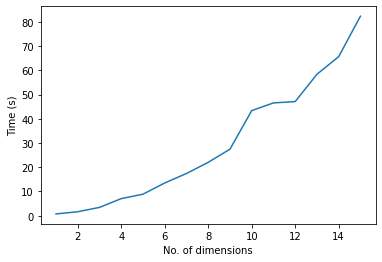

In [12]:
import time
from tqdm.notebook import tqdm

space=[]
times=[]
# loop over number of dimensions
for n,i in zip(range(0,15),tqdm(range(0,15))):
    space.append([0,100])
    opt=Optimizer(space, "GP",n_initial_points=6)
    # Tell 5 random points
    opt.tell(opt.ask(n_points=5),[1,1,1,1,1])
    start = time.time()
    opt.ask(space_fill='stbr', n_points=10)
    end = time.time()
    times.append(end - start)

# print time against dimensions
plt.plot(range(1,16),np.array(times))
plt.xlabel("No. of dimensions")
plt.ylabel("Time (s)")